In [1]:
# Import packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model, Sequential
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os

In [2]:
# Load data from file
train_df=pd.read_csv('src/mitbih_train.csv',header=None)
test_df=pd.read_csv('src/mitbih_test.csv',header=None)

# Create data and labels from dataset
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)



##############################
### MODEL 00 ###

Original model performance
--------------------
Confusion matrix
       0      1      2      3      4
0  0.980  0.114  0.125  0.061  0.028
1  0.011  0.867  0.021  0.009  0.002
2  0.004  0.011  0.826  0.087  0.004
3  0.002  0.000  0.016  0.843  0.000
4  0.003  0.008  0.012  0.000  0.966
Average accuracy
0.8965509831879344

CNN + KNN performance
--------------------
Num Neighbors: 4
Confusion matrix
       0      1      2      3      4
0  0.975  0.081  0.022  0.047  0.003
1  0.010  0.914  0.009  0.008  0.000
2  0.008  0.005  0.954  0.156  0.001
3  0.002  0.000  0.011  0.789  0.000
4  0.004  0.000  0.004  0.000  0.997
Average accuracy
0.9257500374885522


##############################
### MODEL 01 ###

Original model performance
--------------------
Confusion matrix
       0      1      2      3      4
0  0.971  0.126  0.088  0.094  0.024
1  0.013  0.862  0.011  0.000  0.002
2  0.007  0.009  0.873  0.146  0.007
3  0.003  0.003  0.016  0.

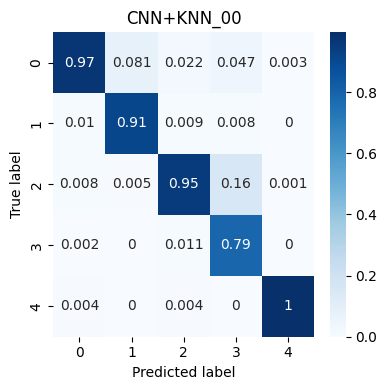

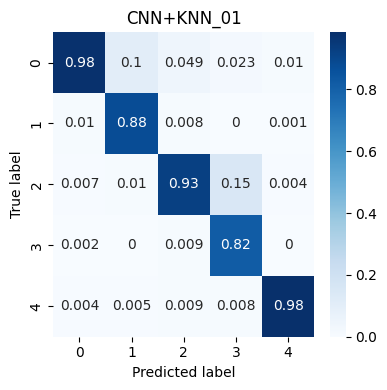

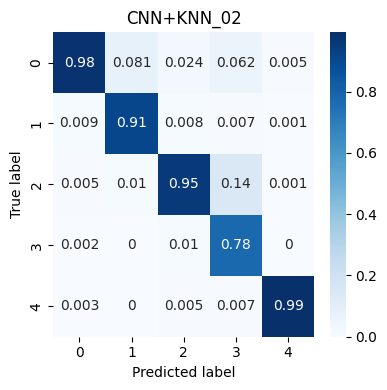

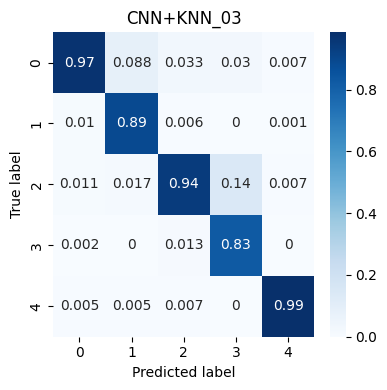

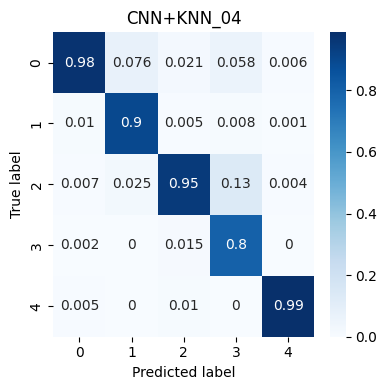

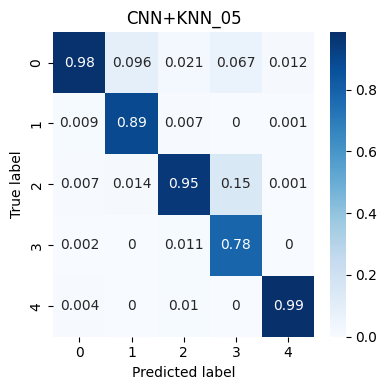

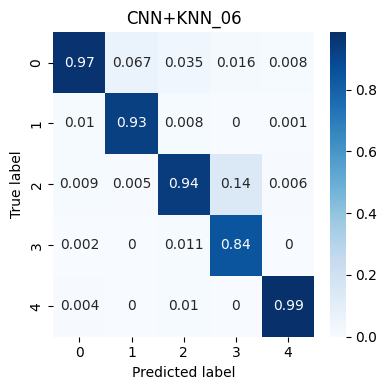

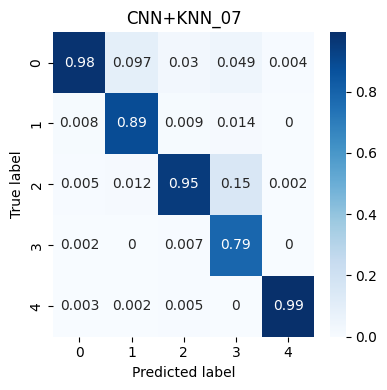

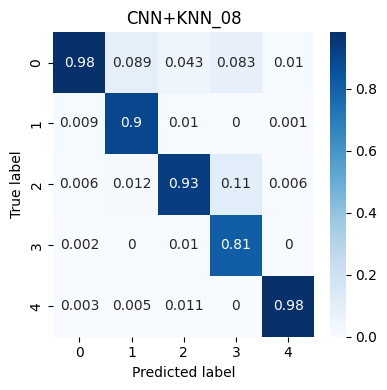

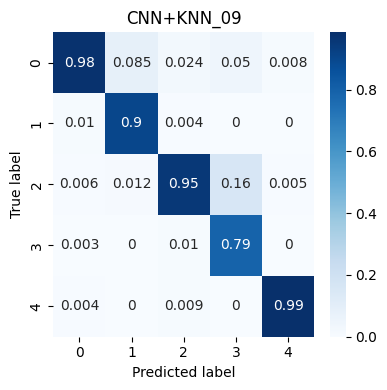

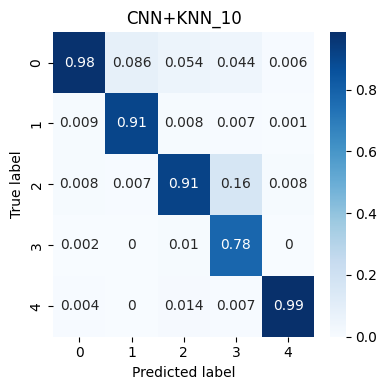

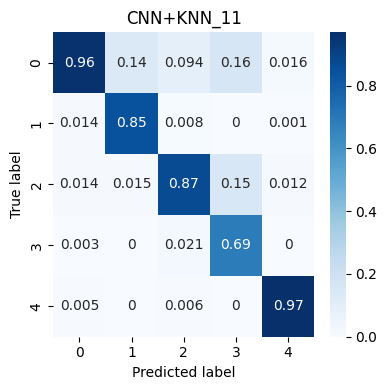

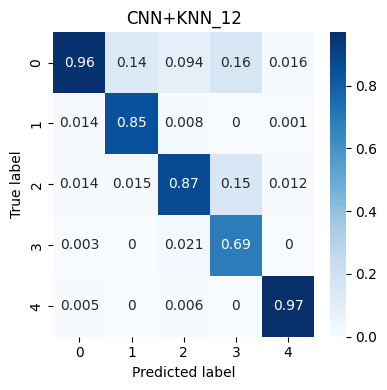

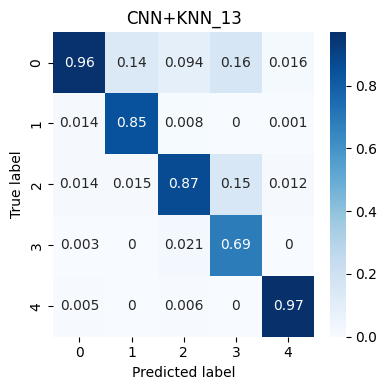

In [3]:
model_num = 0
model_path = 'models/cnn/model_' + f"{model_num:02}" + '.keras'
while os.path.exists(model_path):

    # Load complete model 
    model = keras.models.load_model(model_path)
    #model.summary()

    # Calculate performance or complete model
    y_prediction_cnn = model.predict(X_test, verbose=0)
    y_prediction_cnn = np.argmax (y_prediction_cnn, axis = 1)
    y_test_cnn=np.argmax(y_test, axis=1)

    # Create confusion matrix and normalize it over predicted (columns)
    result_cnn = confusion_matrix(y_test_cnn, y_prediction_cnn , normalize='pred')
    classes = [0,1,2,3,4]
    result_cnn_norm = np.around(result_cnn, 3)
    mat_result_cnn = pd.DataFrame(result_cnn_norm,
                        index = classes, 
                        columns = classes)
    total_pred_cnn = np.trace(result_cnn) / 5

    # Extract submodel ending at last convolution layer
    for n in range(len(model.layers)-1, 0, -1):
        layer = model.layers[n]
        # Skip if not convolution
        if 'conv' not in layer.name:
            continue
        # Define submodel ending at current convolution layer
        mymodel = Model(inputs=model.inputs, outputs=model.layers[n].output)
        break

    # Generate dataset from the output of submodel
    X_test_knn = mymodel.predict(X_test, verbose=0)[:,:,0]
    X_train_knn = mymodel.predict(X_train, verbose=0)[:,:,0]

    # Train KNN network for different number of neighbors
    knn_r_acc = []
    for num_neighbors in range(3, 8):
        # Define KNN
        knn_model = KNeighborsRegressor(n_neighbors=num_neighbors)
        # Train KNN model
        knn_model.fit(X_train_knn, y_train)
        # Extract trained model scores
        train_score = knn_model.score(X_train_knn,y_train)
        test_score = knn_model.score(X_test_knn,y_test)
        # Store scores
        knn_r_acc.append((num_neighbors, test_score ,train_score))
    df = pd.DataFrame(knn_r_acc, columns=['K','Test Score','Train Score'])

    # Predict with best KNN
    best_neigh = int(df.iloc[df['Test Score'].idxmax()]['K'])
    knn_best = KNeighborsRegressor(n_neighbors=best_neigh)
    knn_best.fit(X_train_knn, y_train)

    # Calculate performance of best KNN
    y_prediction_knn = knn_best.predict(X_test_knn)
    y_prediction_knn = np.argmax(y_prediction_knn, axis = 1)
    y_test_knn=np.argmax(y_test, axis=1)

    # Create confusion matrix and normalize it over predicted (columns)
    result_knn = confusion_matrix(y_test_knn, y_prediction_knn , normalize='pred')
    classes = [0,1,2,3,4]
    result_knn_norm = np.around(result_knn, 3)
    mat_result_knn = pd.DataFrame(result_knn_norm,
                        index = classes, 
                        columns = classes)
    total_pred_knn = np.trace(result_knn) / 5

    # Print confusion matrix to image
    model_name = "CNN+KNN_" + f"{model_num:02}"
    log_dir = "logs/cnn+knn/"
    figure = plt.figure(figsize=(4, 4))
    sns.heatmap(mat_result_knn, annot=True,cmap=plt.cm.Blues)
    plt.title(model_name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
    #plt.show()

    # Print results
    print()
    print()
    print("##############################")
    print("### MODEL " + f"{model_num:02}" + " ###")
    print()
    print("Original model performance")
    print("--------------------")
    print('Confusion matrix')
    print(mat_result_cnn)
    print('Average accuracy')
    print(total_pred_cnn)
    print()
    print("CNN + KNN performance")
    print("--------------------")
    print("Num Neighbors: " + str(best_neigh))
    print('Confusion matrix')
    print(mat_result_knn)
    print('Average accuracy')
    print(total_pred_knn)

    model_num += 1
    model_path = 'models/cnn/model_' + f"{model_num:02}" + '.keras'


